## Notebook setup

In [101]:
import sys

sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

%matplotlib inline

In [102]:
conn = ConexionBD.obtener_conexion()

## Data Exploration

**Data setup**

In [103]:
query = """
    SELECT fecha_valor, importe, saldo, categoria, subcategoria, descripcion
    FROM bancapp.movimientos_mview
    WHERE fecha_valor > '2022-12-31'
    ORDER BY fecha_valor
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

**Expenses dataframe**

In [104]:
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria", "subcategoria", "descripcion"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1909 entries, 1 to 2203
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_valor   1909 non-null   datetime64[ns]
 1   mes_valor     1909 non-null   int32         
 2   anio_valor    1909 non-null   int32         
 3   importe       1909 non-null   float64       
 4   categoria     1909 non-null   object        
 5   subcategoria  1909 non-null   object        
 6   descripcion   1909 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(3)
memory usage: 104.4+ KB


Tenemos un total de **1909** gastos registrados

In [105]:
df_gastos.describe()

,fecha_valor,mes_valor,anio_valor,importe
count,1909,1909.000000,1909.000000,1909.000000
mean,2024-07-23 01:26:44.819277312,6.701414,2024.047145,74.557910
min,2023-01-01 00:00:00,1.000000,2023.000000,0.490000
25%,2023-10-28 00:00:00,4.000000,2023.000000,10.250000
50%,2024-08-10 00:00:00,7.000000,2024.000000,27.350000
75%,2025-04-17 00:00:00,10.000000,2025.000000,71.170000
max,2025-12-31 00:00:00,12.000000,2025.000000,9000.000000
std,NaN,3.450747,0.806732,247.899444


### Estudio de atípicos

#### Por estadística

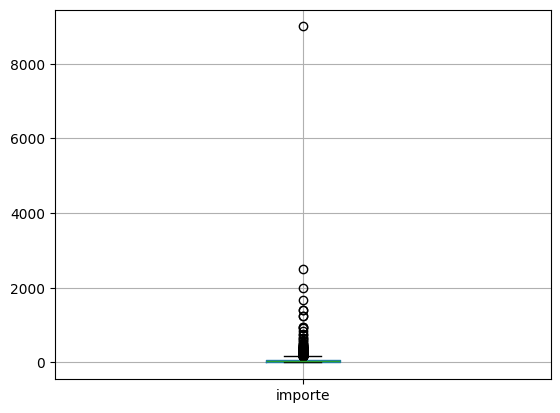

In [106]:
df_gastos.boxplot(column="importe");

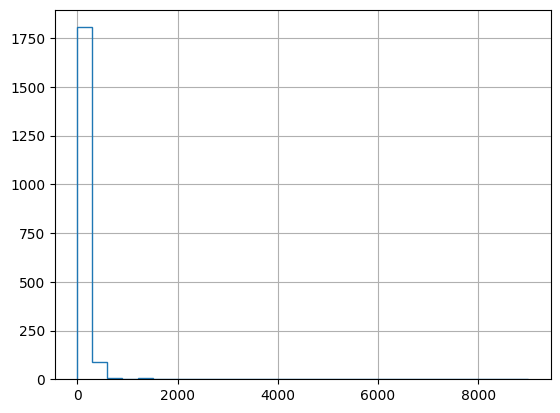

In [107]:
df_gastos.importe.hist(bins=30, histtype='step');

In [108]:
IQR = df_gastos.importe.quantile(0.75) - df_gastos.importe.quantile(0.25)

higher_fence = df_gastos.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  162.55


In [109]:
df_gastos_outliers = df_gastos[df_gastos.importe >= higher_fence]

In [110]:
df_gastos_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 1 to 2167
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_valor   234 non-null    datetime64[ns]
 1   mes_valor     234 non-null    int32         
 2   anio_valor    234 non-null    int32         
 3   importe       234 non-null    float64       
 4   categoria     234 non-null    object        
 5   subcategoria  234 non-null    object        
 6   descripcion   234 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(3)
memory usage: 12.8+ KB


Estadísticamente, los gastos por encima de **162.55** euros son gastos atípicos. 

#### Por agrupación

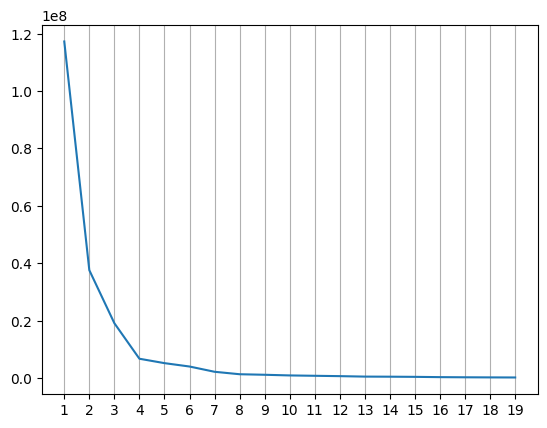

In [111]:
from sklearn.cluster import KMeans

inertia= []
max_clusters = 20
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df_gastos.importe.values.reshape(-1,1))
    inertia.append(kmeans.inertia_)
plt.plot(range(1,max_clusters), inertia);
plt.xticks(ticks=np.arange(1, max_clusters));
plt.grid(axis="x");

Se observa un codo en 4 grupos

**Clustering por densidad**

In [112]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=7.45, min_samples=3)
labels = db.fit_predict(df_gastos.importe.values.reshape(-1,1))

print("Numero de grupos:",len(set(labels)))

Numero de grupos: 5


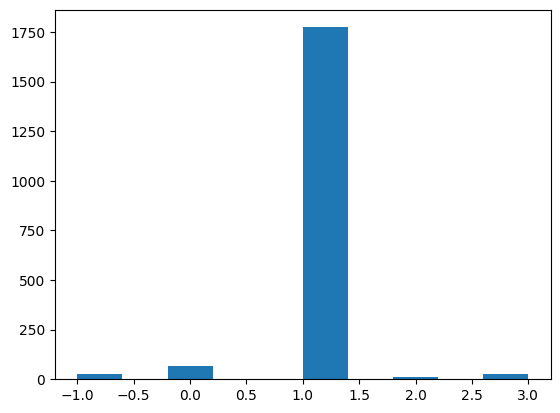

In [113]:
plt.hist(labels);

**Atípicos**

In [114]:
df_gastos["cluster"]= labels

In [115]:
df_gastos[df_gastos.cluster==-1].importe.describe()

count      27.000000
mean     1195.130370
std      1648.444304
min       291.000000
25%       499.500000
50%       738.780000
75%      1250.000000
max      9000.000000
Name: importe, dtype: float64

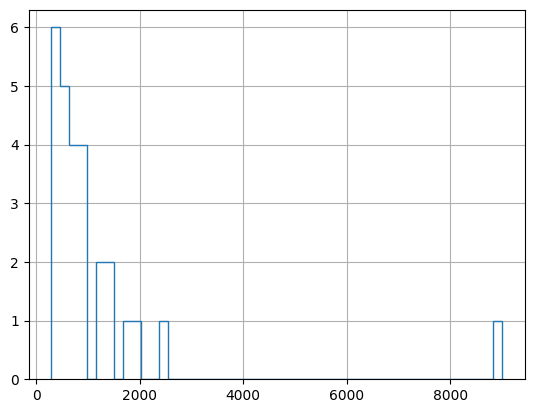

In [116]:
df_gastos[df_gastos.cluster==-1].importe.hist(bins=50, histtype='step');

In [117]:
df_gastos[df_gastos.cluster==-1].sort_values(by="importe")

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,cluster
1694,2025-05-03,5,2025,291.00,Movimientos excluidos,Traspaso entre cuentas,Traspaso emitido Cuenta Nómina Nomina Laura,-1
1823,2025-07-03,7,2025,429.00,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,-1
812,2024-03-07,3,2024,438.00,Movimientos excluidos,Traspaso entre cuentas,Traspaso interno emitido Forfait,-1
1891,2025-08-07,8,2025,450.00,Otros gastos,Transferencias,Transferencia emitida a MCARMEN LOPEZ GUIJARRO...,-1
1515,2025-02-15,2,2025,452.00,Ocio y viajes,Hotel y alojamiento,Pago en CLUB ARAMON FORMIGAL ES,-1
2058,2025-11-03,11,2025,462.00,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,-1
1673,2025-04-27,4,2025,499.00,Educación y salud,Educación,Pago en EL VALLE MADRID ES,-1
1006,2024-06-17,6,2024,500.00,Otros gastos,Cajeros,Reintegro efectivo tarjeta UNICAJA SANCHINARRO ES,-1
35,2023-01-20,1,2023,512.90,Ocio y viajes,Hotel y alojamiento,Pago en GR.ARAMON RECARGA ONLINE FORMIGAL ES,-1
741,2024-01-31,1,2024,585.83,Compras,Compras (otros),Pago en AUTOMEC SA MADRID ES,-1


### Test de similitud entre los grupos de gastos por año, eliminando atípicos

**Test de ANOVA sobre el importe a través de los años**

In [118]:
df_gastos25 = df_gastos[(df_gastos.anio_valor == 2025) & (df_gastos.cluster!=-1)].importe
df_gastos24 = df_gastos[(df_gastos.anio_valor == 2024) & (df_gastos.cluster!=-1)].importe
df_gastos23 = df_gastos[(df_gastos.anio_valor == 2023) & (df_gastos.cluster!=-1)].importe

**Test de distribución normal sobre los datos**

In [119]:
def test_normal_dist(series):
    stat, p = stats.shapiro(series)

    return stat, p

In [120]:
_, p25 = test_normal_dist(df_gastos25)
_, p24 = test_normal_dist(df_gastos24)
_, p23 = test_normal_dist(df_gastos23)

print(f"{p25}, {p24}, {p23}")

1.3850614704584133e-34, 9.664559021126066e-33, 3.310882697641564e-31


Los gastos no siguen una distribución normal. Usamos Kruskal–Wallis para comprobar la similitud en la distribución de los datos por año

**Test de Kruskal–Wallis**

In [121]:
f_stat, p_value = stats.kruskal(df_gastos25, df_gastos24, df_gastos23)

print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 0.23856653118582252
p-value: 0.887556350974094


El valor de p-value es mucho mayor que >0.05, de manera que asumimos que no hay diferencias en la distribución de los datos por año

### Análsis de grupos

#### Grupo mayoritario : Alimentación

In [126]:
df_gastos[df_gastos.cluster==1].importe.describe()

count    1774.000000
mean       42.751917
std        49.617437
min         0.490000
25%         9.885000
50%        24.165000
75%        56.690000
max       240.000000
Name: importe, dtype: float64

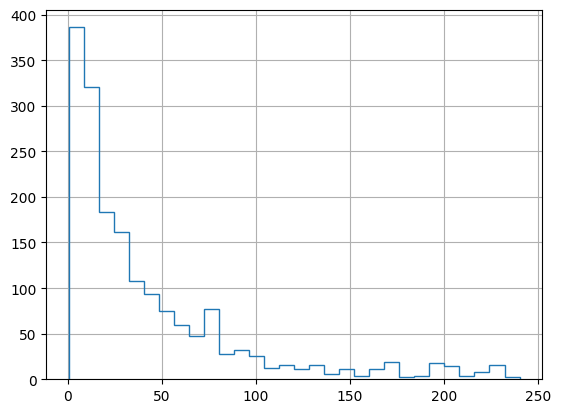

In [127]:
df_gastos[df_gastos.cluster==1].importe.hist(bins=30, histtype='step');

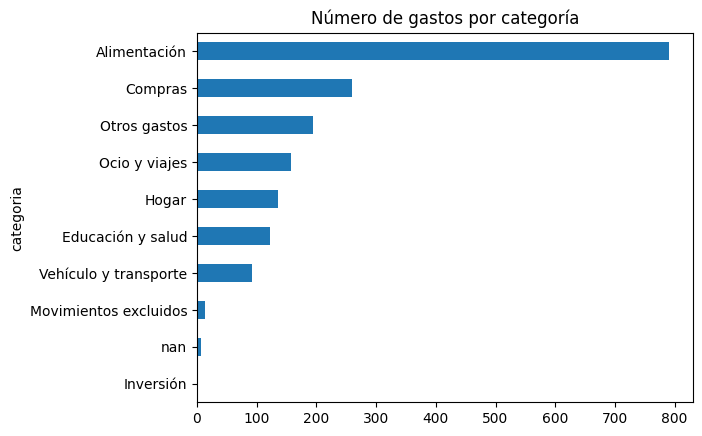

In [128]:
df_gastos[df_gastos.cluster==1].groupby(["categoria"])["importe"].count().sort_values().plot.barh(title="Número de gastos por categoría");

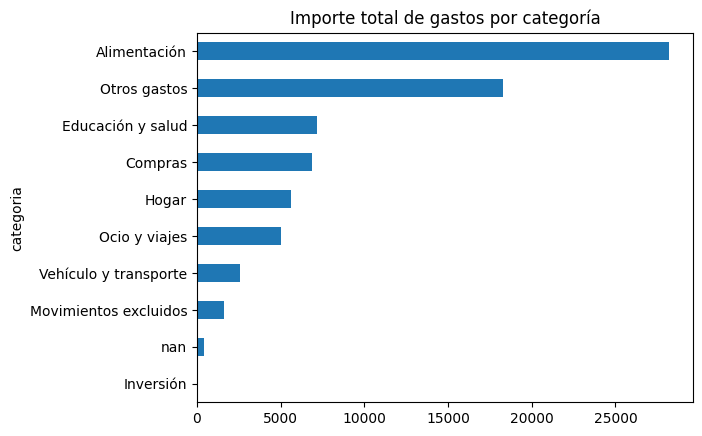

In [129]:
df_gastos[df_gastos.cluster==1].groupby(["categoria"])["importe"].sum().sort_values().plot.barh(title="Importe total de gastos por categoría");

#### Gastos del colegio : Segundo grupo más grande

In [130]:
df_gastos[df_gastos.cluster==0].importe.describe()

count     68.000000
mean     327.180441
std       22.105551
min      300.000000
25%      313.000000
50%      319.500000
75%      343.127500
max      377.530000
Name: importe, dtype: float64

In [131]:
df_gastos[df_gastos.cluster==0]

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,cluster
1,2023-01-01,1,2023,367.14,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,0
3,2023-01-01,1,2023,332.34,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SANCHI...,0
57,2023-01-31,1,2023,301.00,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SANCHI...,0
58,2023-01-31,1,2023,301.00,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,0
109,2023-02-28,2,2023,301.00,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,0
...,...,...,...,...,...,...,...,...
1931,2025-09-01,9,2025,310.53,Alimentación,Supermercados y alimentación,Pago en MERCADONA ONLINE WEB ES,0
2069,2025-11-05,11,2025,347.00,Educación y salud,Deporte y gimnasio,Pago en C.D.E.V. Sanchinarro MARIA TUBAU ES,0
2070,2025-11-05,11,2025,347.00,Educación y salud,Deporte y gimnasio,Pago en C.D.E.V. Sanchinarro MARIA TUBAU ES,0
2118,2025-12-01,12,2025,354.76,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,0


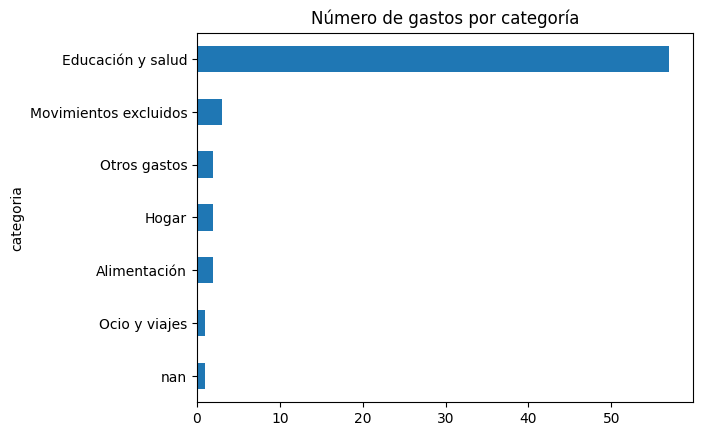

In [132]:
df_gastos[df_gastos.cluster==0].groupby(["categoria"])["importe"].count().sort_values().plot.barh(title="Número de gastos por categoría");

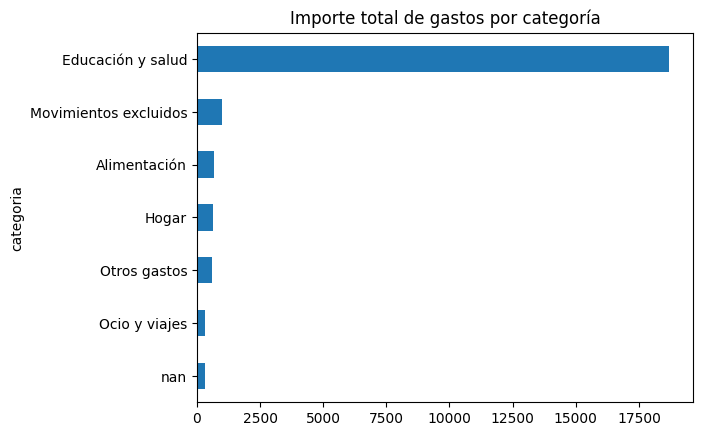

In [133]:
df_gastos[df_gastos.cluster==0].groupby(["categoria"])["importe"].sum().sort_values().plot.barh(title="Importe total de gastos por categoría");

#### Grupo de Otros gastos y Alimentación

In [134]:
df_gastos[df_gastos.cluster==3].importe.describe()

count     29.000000
mean     262.084483
std        4.548964
min      250.000000
25%      263.000000
50%      263.000000
75%      263.000000
max      270.000000
Name: importe, dtype: float64

In [135]:
df_gastos[df_gastos.cluster==3]

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,cluster
155,2023-03-28,3,2023,263.00,Otros gastos,Transferencias,Transferencia emitida a EDY ISABEL MONTOYA MOR...,3
231,2023-05-01,5,2023,263.00,Otros gastos,Transferencias,Transferencia emitida periódica,3
279,2023-05-28,5,2023,263.00,Otros gastos,Transferencias,Transferencia emitida periódica,3
328,2023-06-28,6,2023,263.00,Otros gastos,Transferencias,Transferencia emitida periódica,3
388,2023-08-01,8,2023,270.00,Otros gastos,Cajeros,Reintegro efectivo tarjeta LA CAIXA 5846 MADRI...,3
430,2023-08-18,8,2023,269.90,Alimentación,Supermercados y alimentación,Pago en MERCADONA COMPRA ONLINE WEB ES,3
459,2023-08-29,8,2023,263.00,Otros gastos,Transferencias,Transferencia emitida a EDY ISABEL MONTOYA MOR...,3
467,2023-09-01,9,2023,260.13,Alimentación,Supermercados y alimentación,Pago en MERCADONA COLMENA GETAFE GETAFE ES,3
507,2023-09-29,9,2023,263.00,Otros gastos,Transferencias,Transferencia emitida periódica,3
570,2023-10-30,10,2023,263.00,Otros gastos,Transferencias,Transferencia emitida periódica,3


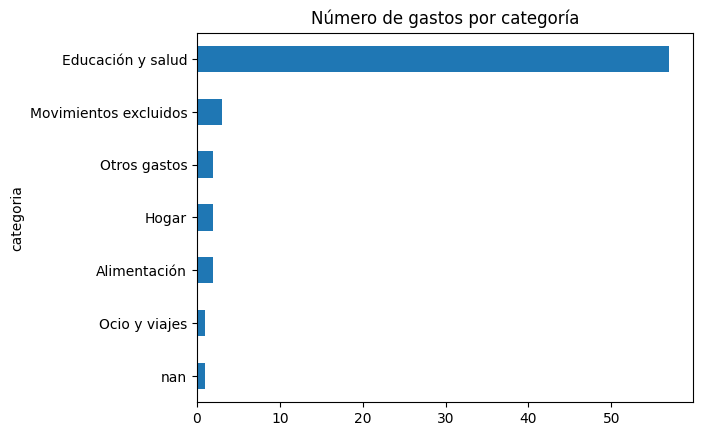

In [84]:
df_gastos[df_gastos.cluster==2].groupby(["categoria"])["importe"].count().sort_values().plot.barh(title="Número de gastos por categoría");

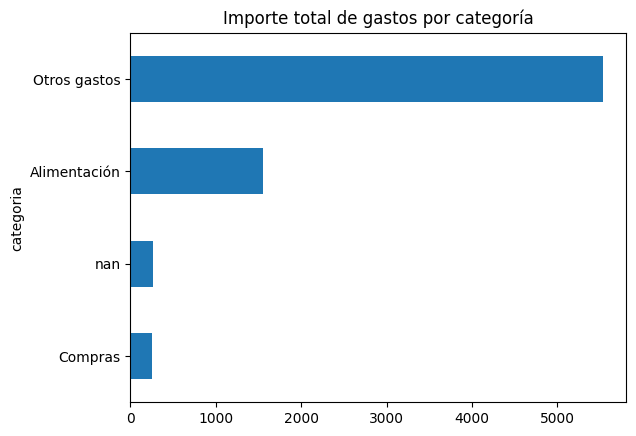

In [136]:
df_gastos[df_gastos.cluster==3].groupby(["categoria"])["importe"].sum().sort_values().plot.barh(title="Importe total de gastos por categoría");

#### Grupo XXX: Pendiente determinar


In [137]:
df_gastos[df_gastos.cluster==2].importe.describe()

count     11.000000
mean     397.446364
std        5.711112
min      385.000000
25%      394.185000
50%      398.400000
75%      400.555000
max      404.130000
Name: importe, dtype: float64

In [138]:
df_gastos[df_gastos.cluster==2]

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,cluster
130,2023-03-13,3,2023,401.11,Hogar,Luz y gas,"Recibo IBERDROLA CLIENTES, S.A.U",2
472,2023-09-01,9,2023,385.00,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,2
1234,2024-10-01,10,2024,392.37,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,2
1307,2024-11-04,11,2024,392.37,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,2
1812,2025-06-30,6,2025,400.00,Otros gastos,Transferencias,Transferencia emitida a CDE RANDORI CUOTA Manu...,2
1988,2025-10-01,10,2025,404.13,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SANCHI...,2
1989,2025-10-01,10,2025,398.40,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,2
2007,2025-10-07,10,2025,400.00,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,2
2059,2025-11-03,11,2025,404.13,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SANCHI...,2
2060,2025-11-03,11,2025,398.40,Educación y salud,Educación,Recibo SERVICIOS EDUCATIVOS EL VALLE DE SAN CHI,2


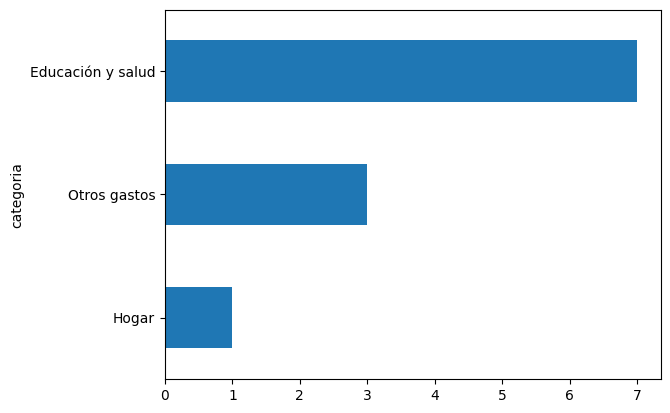

In [139]:
df_gastos[df_gastos.cluster==2].groupby(["categoria"])["importe"].count().sort_values().plot.barh();